# Optimized fits with Grizli products

Grizli provides redshift fitting tools within wrappers that require only a limited number of function calls.  The actual interaction with the spectral data is hidden inside those wrappers.  This notebook provides examples for defining custom objective functions that can be used to optimize any parameters you want to fit / constrain.  

In [1]:
%matplotlib inline

In [2]:
import glob
import time
import os

import numpy as np
np.set_printoptions(precision=3)

import matplotlib.pyplot as plt

import scipy.stats
from scipy.stats import norm, chi2, halfnorm, uniform

import astropy.io.fits as pyfits
import astropy.units as u

import drizzlepac

import grizli
import grizli.stack
print(grizli.__version__)

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol
0.3.0-3-g576cc4e


In [3]:
target = 'ers-grism'
id, z0 = 40776, 1.7418

### MultiBeam object
mb = grizli.multifit.MultiBeam('{0}_{1:05d}.beams.fits'.format(target, id))    

### StackFitter object
st = grizli.stack.StackFitter('{0}_{1:05d}.stack.fits'.format(target, id), fit_stacks=False)

# Initialize flattend arrays for faster likelihood evaluation
for obj in [mb, st]:
    obj.initialize_masked_arrays()

1 ib6o21qmq_flt.fits G102
2 ib6o21qoq_flt.fits G102
3 ib6o21r6q_flt.fits G102
4 ib6o21r8q_flt.fits G102
5 ib6o23rsq_flt.fits G141
6 ib6o23ruq_flt.fits G141
7 ib6o23ryq_flt.fits G141
8 ib6o23s0q_flt.fits G141
Load file ers-grism_40776.stack.fits
Mask 0 additional pixels for ext G102,75.0
Mask 0 additional pixels for ext G141,74.0


In [27]:
# continuum & line templates
templ1 = grizli.utils.load_templates(fwhm=1200, line_complexes=False, stars=False,  
                                     full_line_list=None,  continuum_list=None, fsps_templates=True)

# Convert templates to a matrix for efficient template combination
templ_wave, templ_flux1, is_line = grizli.utils.array_templates(templ1, max_R=3000)

In [28]:
# Use MultiBeam object for fitting
#beam_obj = mb

# Use StackFitter object for fitting [faster]
beam_obj = st

# Get initial fit coefficients
out = beam_obj.xfit_at_z(z=z0, templates=templ1, fitter='nnls', fit_background=True, 
                   get_uncertainties=2, get_design_matrix=False, pscale=None)

chi2, coeffs, coeffs_err, covar = out

# Only use templates with non-zero fit coefficients for now
non_zero = (coeffs_err != 0)
template_names = np.array(list(templ1.keys()))[non_zero[beam_obj.N:]]
templ_flux = templ_flux1[non_zero[beam_obj.N:],:]

param_names = np.hstack(['z', 'err_scale', 'contam_err', 
                        ['bg{0}'.format(i) for i in range(beam_obj.N)], template_names])

print('Parameters\n========\n', '\n'.join(param_names))

Parameters
 z
err_scale
contam_err
bg0
bg1
fsps/fsps_QSF_12_v3_nolines_007.dat
line OIII
line Hb
line Hg
line Hd
line NeIII
line OII
line NeVI
line NeV
line MgII


# Fitting for template coefficients & background offsets

In the first example we define a model that includes the normalization of the SPS and individual templates, along with background offsets for each individual beam (either FLT cutouts or the drizzled combination of them).  We also add terms that modify the uncertainty arrays to 1) allow for an overall scaling of the uncertainty array and 2) include a scaled factor times the contamination array in the error budget.

* The first function (**prior_function**) defines the priors on these parameters, with 

    * $z = N(z_0, 0.01)$

    * $\epsilon = N(1, 0.2)$ (Uncertainty scale factor)

    * $\gamma = \mathrm{half-}N(0.2)$ (Contamination uncertainty factor)

    * The modified pixel uncertainties, $\hat{\sigma}$,  are computed as 

    $\hat{\sigma}^2 = \epsilon\cdot \sigma^2 + (\gamma \cdot C)^2$, 

    where $C$ is the 2D static contamination model.
    

* The second function (**spectrum_generator_coeffs**) generates a 1D model spectrum from the input parameter list.

* The third function (**objfun_scale_contam_full**) defines the full likelihood for this set of parameters.  The last parameter of that function `ret` controls what the function returns, either the model itself or the log-likelihood.

In [29]:
def prior_function(params):
    """
    Prior on redshift and scale parameters
    """
    z_i = params[0]
    err_scale = params[1]
    contam_err = params[2]
    
    # z
    prior = norm.logpdf(z_i, loc=z0, scale=0.01)
    # Error scale
    prior += norm.logpdf(err_scale, loc=1, scale=0.2)
    # Contam scale
    prior += halfnorm.logpdf(contam_err, scale=0.2)
    
    return prior

def spectrum_generator_coeffs(params, templ_wave, templ_flux, beam_obj):
    """
    Generate a template spectrum and fold through compute_model.
    
    Here the model is dotting the normalization `coeffs` with the 
    `templ_flux` template matrix and redshifting to `z_i`.
    
    Parameters
    ----------
    params : array
        Parameter array.  Assumed to have
        
            >>> z_i = params[0]
            >>> coeffs = params[3+beam_obj.N:] # size M

    
    templ_wave : 1D array, size (N)
        Rest-wavelength of the templates.
    
    templ_flux : array, size (M, N)
        Rest-frame fluxes of `M` templates.
    
    beam_obj : `~grizli.multifit.MultiBeam` or `~grizli.stack.StackFitter` object.
    
    Returns
    ----------
    
    spectrum_1d : list
        List of 1D arrays [wavelength, flux].
    
    """
    z_i = params[0]
    coeffs = params[3+beam_obj.N:]

    spectrum_1d = [templ_wave*(1+z_i), np.dot(coeffs, templ_flux/(1+z_i))]
    return spectrum_1d

def objfun_scale_contam_full(params, beam_obj, templ_wave, templ_flux, prior_function, spectrum_generator, ret):
    """
    Full objective function that fits for 
    
    1) redshift
    2) Scaling of the global uncertainties array
    3) Scaling and adding the contamination array in quadrature with the error array
    4) Background pedestal offset
    5) template normalization coefficients
    
    """
    if False:
        params = np.hstack([z0, 1., 0.1, coeffs[non_zero]])
    
    # Pull out parameters
    z_i = params[0]
    err_scale = params[1]
    contam_err = params[2]
    bg_params = params[3:3+beam_obj.N]
    templ_coeffs = params[3+beam_obj.N:]
    
    # scale parameters have to be positive
    if (err_scale < 0) | (contam_err < 0):
        return -np.inf
    
    # Background model
    bg_model = beam_obj.get_flat_background(bg_params, apply_mask=True) 
    
    # Generate test model spectrum
    spectrum_1d = spectrum_generator(params, templ_wave, templ_flux, beam_obj)
    # mfull = model_2d_generator(spectrum_1d, beam_obj)
    mfull = beam_obj.get_flat_model(spectrum_1d, apply_mask=True)
    
    if ret == 'model':
        return mfull, bg_model, spectrum_1d
    
    # Apply scale to uncertainties
    err = np.sqrt(beam_obj.sigma2_mask*err_scale+(contam_err*beam_obj.contamf_mask)**2)
    
    # Residual
    resid = beam_obj.scif_mask - (mfull + bg_model)

    # likelihood
    lnp = norm.logpdf(resid, loc=0, scale=err).sum()
    prior = prior_function(params)
    #print('{0} {1:.1f} {2:.1f}'.format(params, lnp, prior))
    return lnp+prior

In [30]:
# Arguments to objective function
args = (beam_obj, templ_wave, templ_flux, prior_function, 
        spectrum_generator_coeffs, 'lnp')
model_args = (beam_obj, templ_wave, templ_flux, prior_function, 
              spectrum_generator_coeffs, 'model')

# Test objective function
params = np.hstack([z0, 1., 0.1, coeffs[non_zero]])

print('lnlike_0: {0:.1f}'.format(objfun_scale_contam_full(params, *args)))
print('Fit object: {0}\nTime to eval likelihood function:'.format(beam_obj.__class__))
%timeit objfun_scale_contam_full(params, *args)

lnlike_0: 6506.7
Fit object: <class 'grizli.stack.StackFitter'>
Time to eval likelihood function:
1.74 ms ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


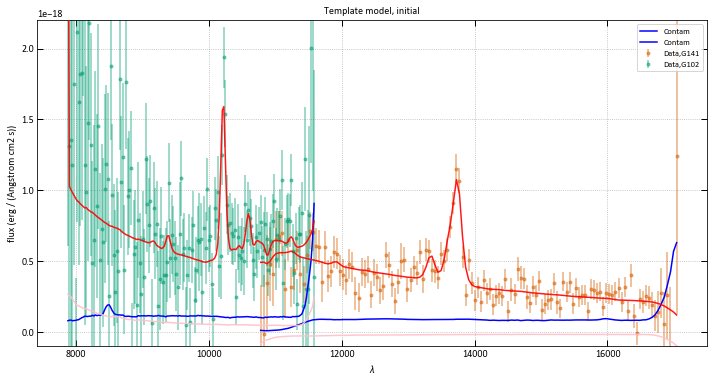

In [31]:
def make_SED_plot(beam_obj, params, objfun, model_args):
    """
    Make a plot of the observed and model spectra
    """
    sp_data = beam_obj.optimal_extract(beam_obj.scif_mask, bin=1)
    
    # Generate a model with a flat spectrum, which will serve to do the flux conversion from
    # instrumental units to cgs flux densities
    sp_flat = beam_obj.optimal_extract(beam_obj.get_flat_model(None), bin=1)
    for g in beam_obj.Ngrism:
        sp_flat[g]['flux'].unit = (u.electron / u.second) / grizli.utils.FLAMBDA_CGS

    sp_contam = beam_obj.optimal_extract(beam_obj.contamf_mask, bin=1)

    # Make plot
    fig = plt.figure(figsize=(12,6))
    
    # Data
    for g in beam_obj.Ngrism:
        scl = 1./sp_flat[g]['flux']
        plt.errorbar(sp_data[g]['wave'], sp_data[g]['flux']*scl, sp_data[g]['err']*scl, 
                     marker='.', color=grizli.utils.GRISM_COLORS[g], alpha=0.5, 
                     linestyle='None', label='Data,'+g)
        
        plt.plot(sp_contam[g]['wave'], sp_contam[g]['flux']*scl, 
                 color='b', zorder=100, label='Contam')

    # Models
    NP = params.shape[0]
    if NP > 1:
        alpha = 0.03
    else:
        alpha = 0.9
    
    for ip in range(NP):
        model, bg, spectrum_1d = objfun(params[ip,:], *model_args)
        sp_model = beam_obj.optimal_extract(model+bg, bin=1)
        sp_bg = beam_obj.optimal_extract(bg, bin=1)

        for g in beam_obj.Ngrism:
            scl = 1./sp_flat[g]['flux']
            plt.plot(sp_model[g]['wave'], (sp_model[g]['flux']*scl).data, 
                     color='r', zorder=100, label=None, alpha=alpha)
            plt.plot(sp_model[g]['wave'], (sp_bg[g]['flux']*scl).data, 
                     color='pink', zorder=100, label=None, alpha=alpha)

    plt.legend()
    plt.ylabel('flux ({0})'.format((sp_data[g]['flux'].unit/scl.unit).__str__())); 
    plt.xlabel(r'$\lambda$')
    plt.grid()

make_SED_plot(beam_obj, params[None,], objfun_scale_contam_full, model_args)
plt.ylim(-0.1e-18, 2.2e-18); plt.title('Template model, initial')

### Sample the parameter space with `emcee`
Now we use the `emcee` module to sample the posterior distribution of the parameters of our model, first initializing the parameters with values consistent with the priors.

In [32]:
####### Full EMCEE chain
NSTEP, NWALKERS = 512, 128
#NSTEP, NWALKERS = 64, 128 # for testing

NDIM = params.size

import emcee

# Initialize
p0 = np.random.normal(size=(NWALKERS, NDIM))
p0[:,0] = norm.rvs(loc=z0, scale=0.005, size=NWALKERS)
p0[:,1] = norm.rvs(loc=1, scale=0.1, size=NWALKERS)
p0[:,2] = halfnorm.rvs(scale=0.2, size=NWALKERS)

# Background and template coefficients
p0[:,3:] *= coeffs_err[non_zero]*3
p0[:,3:] += coeffs[non_zero]

param_names = np.hstack(['z', 'err', 'cont', 
                         ['bg{0}'.format(i) for i in range(beam_obj.N)], 
                         template_names])

In [33]:
### Run the chain
sampler = emcee.EnsembleSampler(NWALKERS, NDIM, objfun_scale_contam_full, threads=1, args=args)
#result = sampler.run_mcmc(p0, NSTEP)
for i, result in enumerate(sampler.sample(p0, iterations=NSTEP)):
    if (i+1) % 64 == 0:
        print("Emcee step {0}/{1}".format(i+1, NSTEP))

# Take second half of chain as post-burn
chain = sampler.chain[:,NSTEP//2:,:].reshape((-1,NDIM))
print(sampler.chain.shape, chain.shape)

Emcee step 64/512
Emcee step 128/512
Emcee step 192/512
Emcee step 256/512
Emcee step 320/512
Emcee step 384/512
Emcee step 448/512
Emcee step 512/512
(128, 512, 15) (32768, 15)


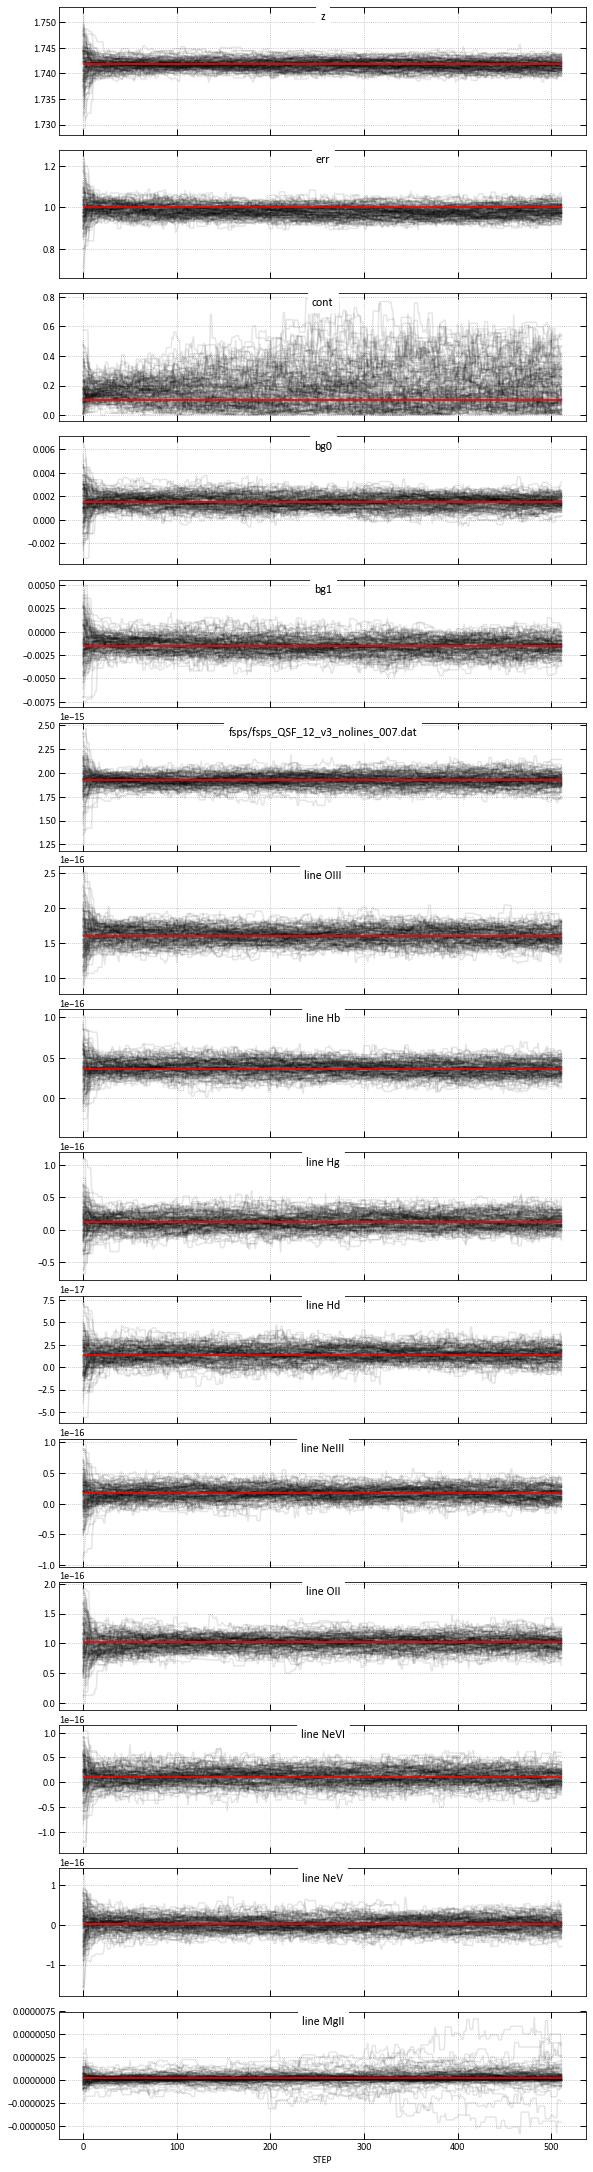

In [34]:
# Show the chains
def show_chain(chain, param_names):
    """
    Make plots of the individual parameter chains to check for convergence
    """
    fig = plt.figure(figsize=[8,2*NDIM])
    for i in range(NDIM):
        ax = fig.add_subplot(NDIM,1,i+1)
        ax.plot(sampler.chain[:,:,i].T, color='k', alpha=0.1)
        ax.hlines(params[i], 0, NSTEP, color='r', linewidth=2, alpha=0.8, zorder=100)
        ax.text(0.5, 0.97, param_names[i], ha='center', va='top', 
                transform=ax.transAxes, fontsize=12, backgroundcolor='w')
        if i == NDIM-1:
            ax.set_xlabel('STEP')
        else:
            ax.set_xticklabels([])

        ax.grid()

    fig.tight_layout(pad=0.1)

show_chain(sampler.chain, param_names)

In [35]:
# Should be between 0.25 and 0.5 as per emcee documentation
print(sampler.acceptance_fraction)

[ 0.338  0.326  0.342  0.33   0.348  0.344  0.33   0.354  0.332  0.332
  0.367  0.326  0.346  0.344  0.334  0.297  0.316  0.348  0.312  0.328
  0.311  0.312  0.336  0.359  0.256  0.346  0.361  0.299  0.289  0.318
  0.377  0.301  0.297  0.346  0.348  0.277  0.359  0.322  0.291  0.354
  0.359  0.307  0.34   0.35   0.326  0.354  0.344  0.324  0.291  0.301
  0.344  0.303  0.357  0.352  0.307  0.363  0.336  0.359  0.33   0.365
  0.328  0.342  0.307  0.326  0.357  0.318  0.23   0.295  0.322  0.316
  0.307  0.289  0.32   0.348  0.363  0.309  0.344  0.363  0.291  0.318
  0.357  0.361  0.309  0.32   0.402  0.305  0.268  0.312  0.33   0.271
  0.273  0.34   0.279  0.299  0.322  0.293  0.352  0.314  0.332  0.312
  0.285  0.312  0.318  0.363  0.33   0.342  0.326  0.316  0.311  0.309
  0.307  0.297  0.303  0.34   0.35   0.334  0.32   0.318  0.348  0.332
  0.338  0.365  0.289  0.334  0.35   0.35   0.332  0.34 ]


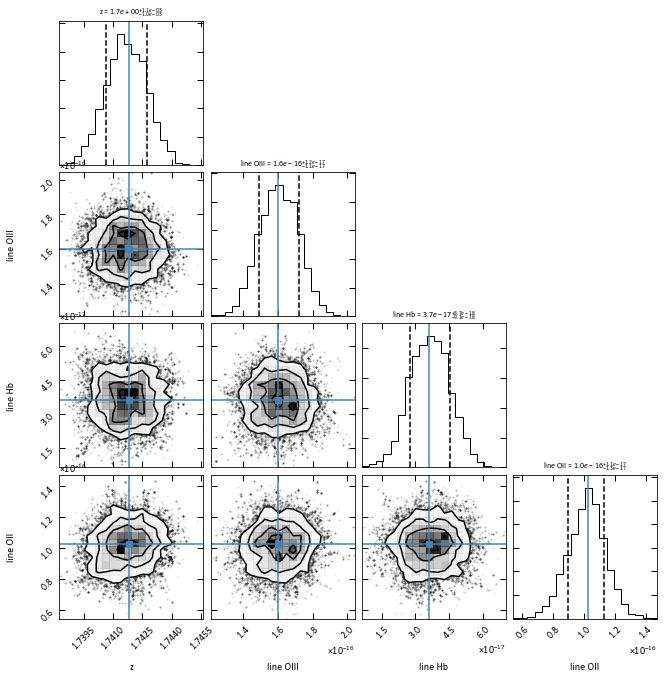

In [36]:
def show_corner(flat_chain, param_names):
    """
    Make corner plot
    """
    import corner

    #print(param_names)
    show_params = ['z', 'line SIII', 'line SII', 'line Ha', 'line OIII', 'line Hb', 'line OII']
    show_params.extend(['beta_norm', 'beta_slope'])

    clip = np.zeros(NDIM, dtype=bool)
    #clip[3+beam_obj.N:] = True
    for p in show_params:
        clip[param_names == p] = True

    #print(param_names[clip])
    fig = corner.corner(flat_chain[:,clip], bins=20, range=None, weights=None, 
                        color='k', smooth=None, smooth1d=None, labels=param_names[clip], 
                        label_kwargs={'fontsize':10}, show_titles=True, title_fmt='.1e', 
                        title_kwargs={'fontsize':8}, truths=params[clip], 
                        truth_color='#4682b4', scale_hist=False, quantiles=(0.16, 0.84), 
                        verbose=False, fig=None, max_n_ticks=5, top_ticks=False, 
                        use_math_text=True, hist_kwargs=None)

    fig.savefig('chain.png')

show_corner(chain, param_names)

In [37]:
### Compute statistics from the chain

# Maximum a-posteriori (MAP)
xi = np.argmax(sampler.lnprobability[:,NSTEP//2:].flatten())
chain_map = chain[xi,:]

# Percentiles
stats = np.percentile(chain, [16, 50, 84], axis=0)
for i in range(len(param_names)):
    print('{0:<12s} {1} {2}'.format(param_names[i], chain_map[i:i+1], stats[:,i]))

z            [ 1.743] [ 1.741  1.742  1.743]
err          [ 0.962] [ 0.948  0.978  1.008]
cont         [ 0.037] [ 0.047  0.158  0.333]
bg0          [ 0.002] [ 0.001  0.002  0.002]
bg1          [-0.001] [-0.002 -0.002 -0.001]
fsps/fsps_QSF_12_v3_nolines_007.dat [  1.920e-15] [  1.858e-15   1.925e-15   1.995e-15]
line OIII    [  1.606e-16] [  1.491e-16   1.604e-16   1.721e-16]
line Hb      [  3.835e-17] [  2.744e-17   3.653e-17   4.519e-17]
line Hg      [  8.750e-18] [  1.446e-18   1.299e-17   2.595e-17]
line Hd      [  1.553e-17] [  6.729e-18   1.461e-17   2.281e-17]
line NeIII   [  2.102e-17] [  6.109e-18   1.678e-17   2.768e-17]
line OII     [  9.720e-17] [  8.964e-17   1.023e-16   1.131e-16]
line NeVI    [  1.774e-17] [ -4.706e-18   1.038e-17   2.727e-17]
line NeV     [  1.199e-17] [ -1.529e-17   2.281e-18   1.976e-17]
line MgII    [  1.807e-07] [ -6.507e-08   2.209e-07   7.521e-07]


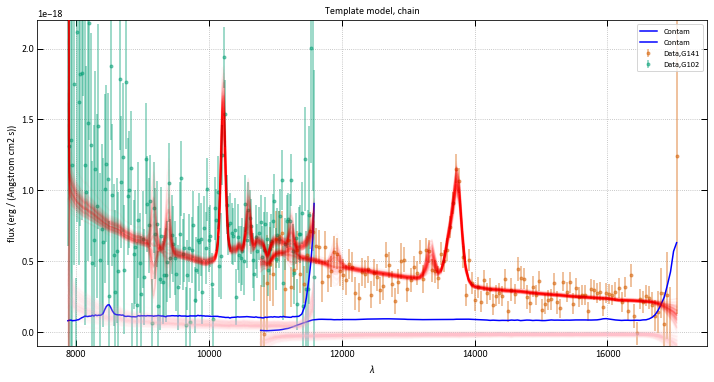

In [38]:
# Show spectrum with draws from the posterior
make_SED_plot(beam_obj, sampler.chain[:,-1,:], objfun_scale_contam_full, model_args)
plt.ylim(-0.1e-18, 2.2e-18); plt.title('Template model, chain')

## Parameterized continuum

The next example shows how to define additional parameters in the model, where we now parameterize the continuum as

  $f_\lambda = \alpha\cdot\left(\frac{\lambda}{1.4\,\mu\mathrm{m}}\right)^{\beta}$, 
  
i.e., a simple continuum appropriate for a high-z Lyman-break galaxy, along with the same emission line templates as before.  Now the parameters of the model are $\alpha$, $\beta$, parameters for optimizing the uncertainties, background offsets, and normalization of the emission line templates.

We keep the noise modification terms and their priors from the previous example, and add a prior on $\beta = \mathrm{Uniform}(-3,2)$.

In [39]:
def prior_beta(params):
    """
    Prior on redshift and scale parameters
    """
    z_i = params[0]
    err_scale = params[1]
    contam_err = params[2]
    beta_slope = params[3]
    #norm = params[4]
    
    # z
    prior = norm.logpdf(z_i, loc=z0, scale=0.01)
    # Error scale
    prior += norm.logpdf(err_scale, loc=1, scale=0.2)
    # Contam scale
    prior += halfnorm.logpdf(contam_err, scale=0.2)
    # Beta
    prior += uniform(loc=-3, scale=5).logpdf(beta_slope)

    return prior

def spectrum_generator_beta(params, templ_wave, line_templ_flux, beam_obj):
    """
    Continuum with parameters for continum ~ norm * (wave/1.e4e) ** beta 
    plus emission lines
    """
    z_i = params[0]
    beta_slope = params[3]
    beta_norm = params[4+beam_obj.N]
    coeffs = params[5+beam_obj.N:]
    
    #print('yyy', beta_slope, beta_norm, coeffs, coeffs.shape, line_templ_flux.shape)
    
    beta_continuum = beta_norm*(templ_wave*(1+z_i)/1.4e4)**beta_slope
    # e.g., trivial step-function IGM
    beta_continuum[templ_wave*(1+z_i) < 1216.] *= 0
    
    emlines = np.dot(coeffs, line_templ_flux/(1+z_i))
    spectrum_1d = [templ_wave*(1+z_i), beta_continuum + emlines]
    return spectrum_1d

def objfun_beta(params, beam_obj, templ_wave, line_templ_flux, prior_function, 
                spectrum_generator, ret):
    """
    Full objective function, fitting for 
    
    1) redshift
    2) Scaling of the global error array
    3) Adding the contamination array in quadrature with the error array
    4) Beta slope
    6) Background pedestal offset
    7) Beta norm
    8) template coefficients
    
    """
    if False:
        params = np.hstack([z0, 1., 0.1, coeffs[non_zero]])
    
    # Pull out parameters
    z_i = params[0]
    err_scale = params[1]
    contam_err = params[2]
    beta_slope = params[3]
    bg_params = params[4:4+beam_obj.N]
    beta_norm = params[4+beam_obj.N]
    templ_coeffs = params[5+beam_obj.N:]
    
    #print('xx', z_i, err_scale, contam_err, beta_slope, bg_params, beta_norm, templ_coeffs, bg_params)
    #print('xx', params, line_templ_flux.shape)
    
    # scale parameters have to be positive
    if (err_scale < 0) | (contam_err < 0) & (ret != 'model'):
        return -np.inf
    
    # Background model
    bg_model = beam_obj.get_flat_background(bg_params, apply_mask=True)

    # Generate test model spectrum
    spectrum_1d = spectrum_generator(params, templ_wave, line_templ_flux, beam_obj)
    # mfull = model_2d_generator(spectrum_1d, beam_obj)

    mfull = beam_obj.get_flat_model(spectrum_1d, apply_mask=True)
    
    if ret == 'model':
        return mfull, bg_model, spectrum_1d
    
    # Apply scale to uncertainties
    err = np.sqrt(beam_obj.sigma2_mask*err_scale+(contam_err*beam_obj.contamf_mask)**2)
    
    # Residual
    resid = beam_obj.scif_mask - (mfull + bg_model)
    
    # likelihood
    lnp = norm.logpdf(resid, loc=0, scale=err).sum()
    prior = prior_function(params)
    #print('{0:.1e} {1:.1f} {2} {3:.1f} {4:.1f}'.format(beta_norm, beta_slope, bg_params, lnp, prior))
    return lnp+prior

In [40]:
### Redefine the template matrix for the new model
from collections import OrderedDict

# Make template set with a fake continuum template + lines
templ = OrderedDict()
tx = templ1['fsps/fsps_QSF_12_v3_nolines_001.dat']
templ_flat = grizli.utils.SpectrumTemplate(wave=tx.wave, flux=(tx.wave/1.4e4)**-1)
templ['beta_norm'] = templ_flat
for k in templ1:
    if k.startswith('line'):
        templ[k] = templ1[k]

# Get initial fit coefficients
out = beam_obj.xfit_at_z(z=z0, templates=templ, fitter='nnls', fit_background=True, 
                   get_uncertainties=2, get_design_matrix=False, pscale=None)

chi2, coeffs, coeffs_err, covar = out

# Matrix for efficient template combination
templ_wave, templ_flux1, is_line = grizli.utils.array_templates(templ, max_R=3000)

# Only use templates with non-zero fit coefficients for now
non_zero = (coeffs_err != 0)
line_templ_flux = templ_flux1[non_zero[beam_obj.N:],:]
line_templ_flux = line_templ_flux[1:,:] # Don't include continuum template here, which will be generated internally

#print(line_templ_flux.shape, np.trapz(line_templ_flux[0,:], templ_wave))
template_names = np.array(list(templ.keys()))[non_zero[beam_obj.N:]]
param_names = np.hstack(['z', 'err', 'cont', 'beta_slope', 
                         ['bg{0}'.format(i) for i in range(beam_obj.N)], template_names])
print('\n'.join(param_names))

z
err
cont
beta_slope
bg0
bg1
beta_norm
line OIII
line Hb
line Hg
line Hd
line NeIII
line OII
line NeVI
line MgII


lnlike_0: 6479.6
Fit object: <class 'grizli.stack.StackFitter'>
Time to eval likelihood function:
2.95 ms ± 80.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


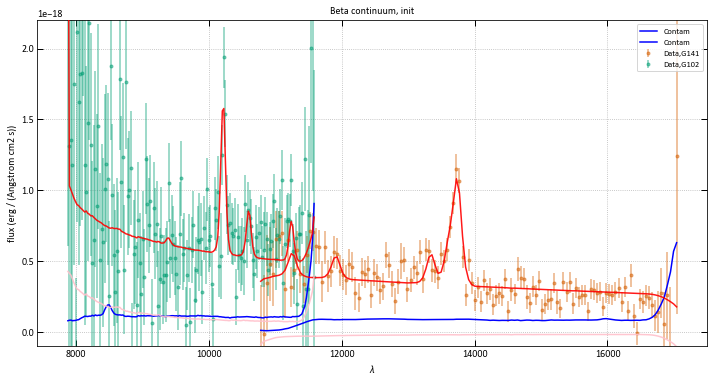

In [41]:
# Arguments to objective function
args = (beam_obj, templ_wave, line_templ_flux, prior_beta, 
        spectrum_generator_beta, 'lnp')
model_args = (beam_obj, templ_wave, line_templ_flux, prior_beta, 
              spectrum_generator_beta, 'model')

# Test objective function
params = np.hstack([z0, 1., 0.1, -1, coeffs[non_zero]])

print('lnlike_0: {0:.1f}'.format(objfun_beta(params, *args)))
print('Fit object: {0}\nTime to eval likelihood function:'.format(beam_obj.__class__))
%timeit objfun_beta(params, *args)

#%timeit objfun_beta(params, *args)

# Show SED with draws from the posterior
make_SED_plot(beam_obj, params[None,:], objfun_beta, model_args)
plt.ylim(-0.1e-18, 2.2e-18); plt.title('Beta continuum, init')

In [19]:
####### Full chain
NSTEP, NWALKERS = 512, 128
#NSTEP, NWALKERS = 64, 128 # for testing

NDIM = params.size

import emcee

# Initialize
p0 = np.random.normal(size=(NWALKERS, NDIM))
p0[:,0] = norm.rvs(loc=z0, scale=0.01, size=NWALKERS) # z
p0[:,1] = norm.rvs(loc=1, scale=0.1, size=NWALKERS) # err
p0[:,2] = halfnorm.rvs(scale=0.2, size=NWALKERS) # scale
p0[:,3] = uniform(loc=-3, scale=5).rvs(size=NWALKERS) # beta

# Background and template coefficients
p0[:,4:] *= coeffs_err[non_zero]*3
p0[:,4:] += coeffs[non_zero]

In [20]:
### Run the chain
sampler = emcee.EnsembleSampler(NWALKERS, NDIM, objfun_beta, threads=1, args=args)
#result = sampler.run_mcmc(p0, NSTEP)
for i, result in enumerate(sampler.sample(p0, iterations=NSTEP)):
    if (i+1) % 64 == 0:
        print("Emcee step {0}/{1}".format(i+1, NSTEP))

# Take second half of chain as post-burn
chain = sampler.chain[:,NSTEP//2:,:].reshape((-1,NDIM))
print(sampler.chain.shape, chain.shape) 

Emcee step 64/512
Emcee step 128/512
Emcee step 192/512
Emcee step 256/512
Emcee step 320/512
Emcee step 384/512
Emcee step 448/512
Emcee step 512/512
(128, 512, 15) (32768, 15)


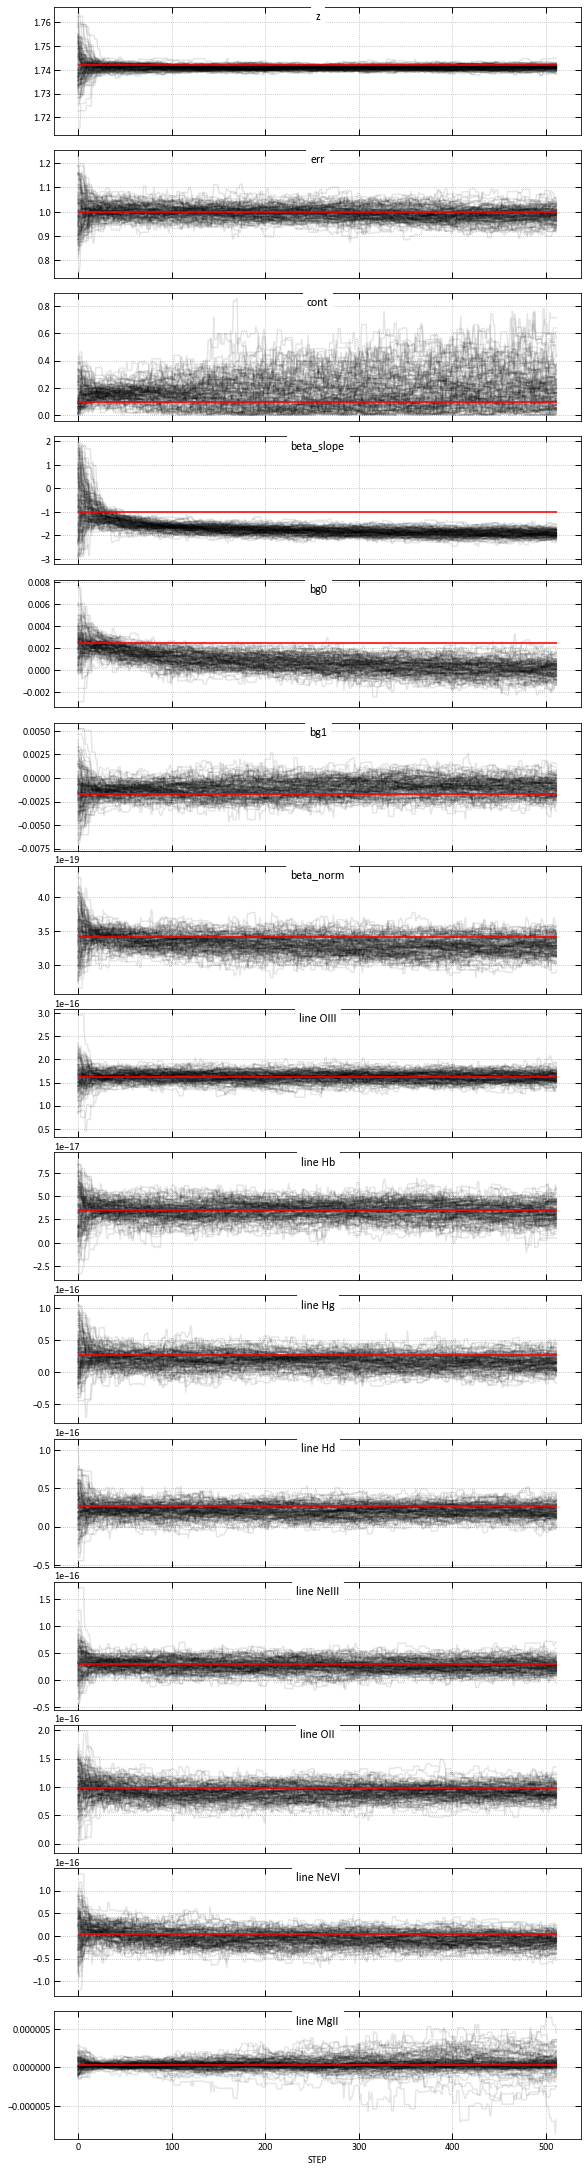

In [23]:
show_chain(sampler.chain, param_names)

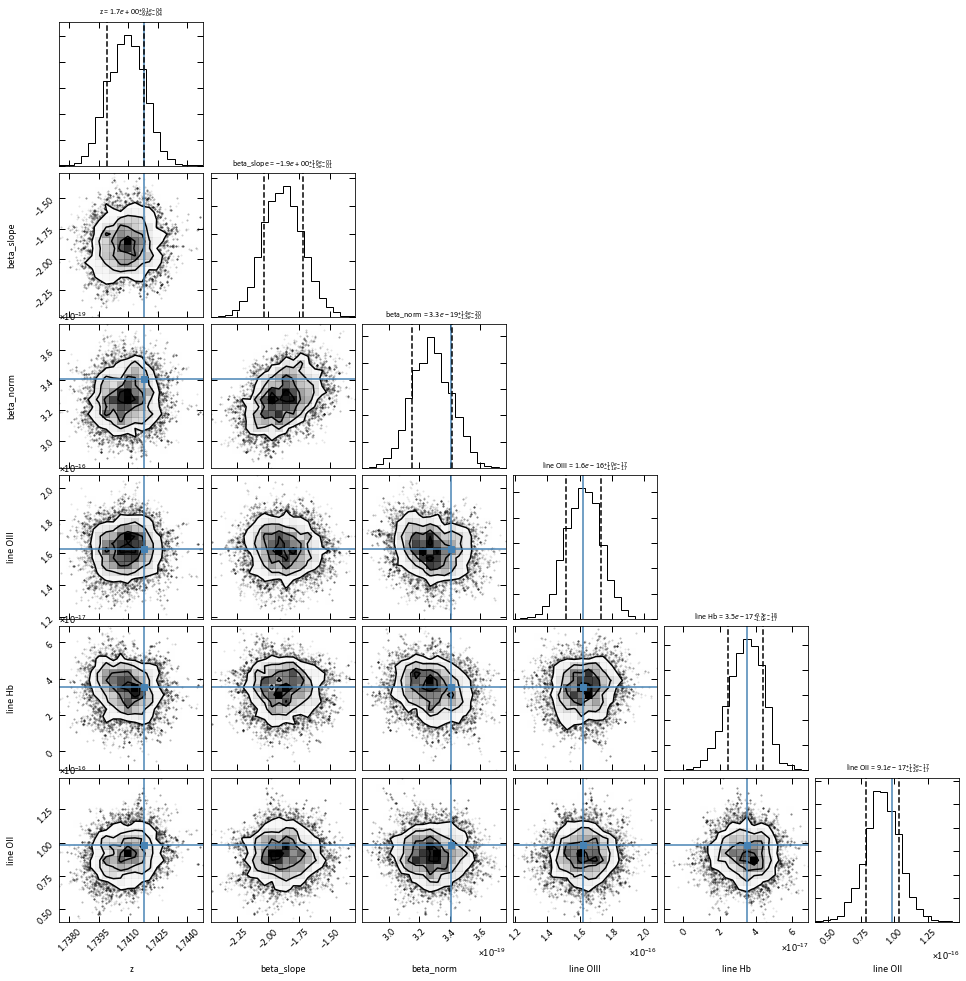

In [24]:
show_corner(chain, param_names)

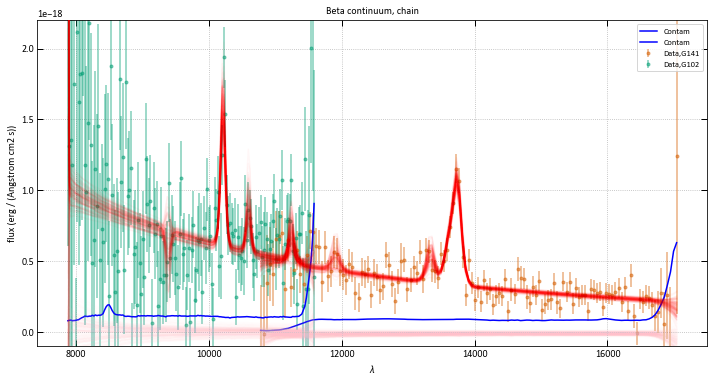

In [25]:
# Show SED with draws from the posterior
make_SED_plot(beam_obj, sampler.chain[:,-1,:], objfun_beta, model_args)
plt.ylim(-0.1e-18, 2.2e-18); plt.title('Beta continuum, chain')